In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


2024-06-08 17:47:31.119573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:47:31.119685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:47:31.250290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print('number of train sample', train.shape[0])
print('number of test sample', test.shape[0])

number of train sample 42000
number of test sample 28000


In [5]:
train.info

<bound method DataFrame.info of        label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       

In [6]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"], axis = 1)

Y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [7]:
train.isnull().values.any()

False

In [8]:
test.isnull().values.any()

False

In [9]:
X_train.values.shape

(42000, 784)

In [10]:
X_train = X_train / 255.0
X_test = test / 255.0

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [12]:
def show(x, y, index):
    plt.figure(figsize=(15,2))
    plt.imshow(x[index], cmap=plt.cm.binary)

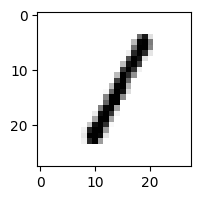

In [13]:
show(X_train, Y_train, 7)

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

train_datagen.fit(X_train)

In [15]:
def show_loss_and_acc(history):
    df = pd.DataFrame(history.history)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df['loss'], label='Training Loss')
    if 'val_loss' in df:
        plt.plot(df['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    if 'accuracy' in df:
        plt.plot(df['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in df:
            plt.plot(df['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [16]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(
    train_datagen.flow(X_train, Y_train, batch_size=64),
    epochs=200,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=True
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/591 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.1033 - loss: 4.4399

I0000 00:00:1717868892.295309      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 55s 54ms/step - accuracy: 0.1241 - loss: 4.1318 - val_accuracy: 0.4186 - val_loss: 2.6419 - learning_rate: 1.0000e-04
Epoch 2/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.2517 - loss: 3.2448 - val_accuracy: 0.6769 - val_loss: 2.2260 - learning_rate: 1.0000e-04
Epoch 3/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3580 - loss: 2.8191 - val_accuracy: 0.8345 - val_loss: 1.9122 - learning_rate: 1.0000e-04
Epoch 4/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.4736 - loss: 2.4944 - val_accuracy: 0.8831 - val_loss: 1.6313 - learning_rate: 1.0000e-04
Epoch 5/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5807 - loss: 2.2173 - val_accuracy: 0.8929 - val_loss: 1.4233 - learning_rate: 1.0000e-04
Epoch 6/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6737 - loss: 1.9797 - val_accuracy: 0.9376 - val_loss: 1.2617 - learning_rate: 1.0000e-04
Epoch 7/200
591/591 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - a

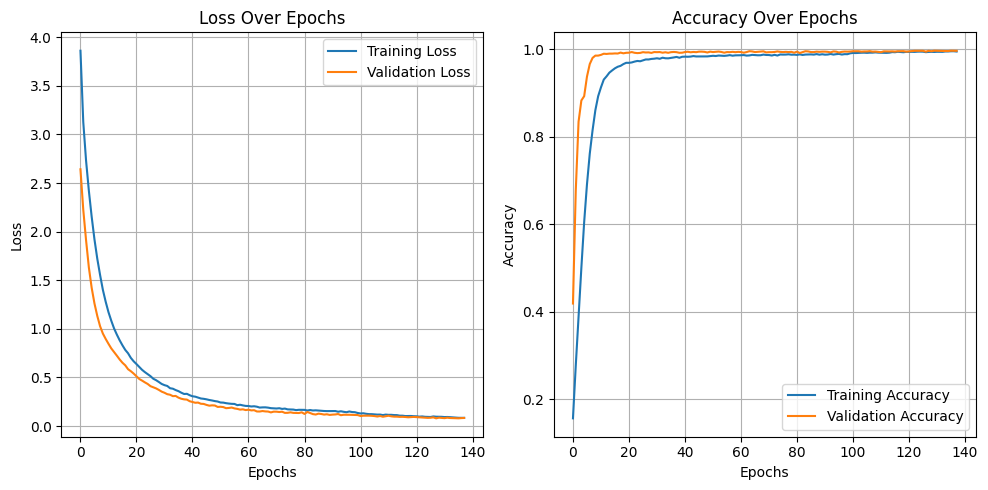

In [17]:
show_loss_and_acc(history)

In [18]:
results = np.zeros((X_test.shape[0],10))
results = results + model.predict(X_test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, 28001),name="ImageId"), results], axis=1)
submission.to_csv("finish_digit_recognizer4.csv", index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


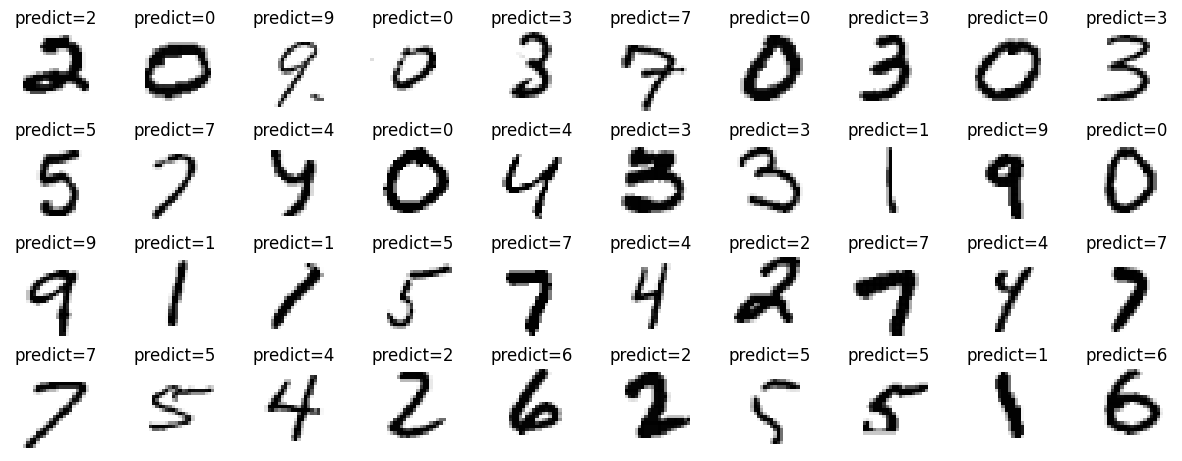

In [19]:
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i], y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()